In [83]:
import warnings
#C:\Users\lxmz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_forecasting
warnings.filterwarnings("ignore")  # avoid printing out absolute paths
import copy
import warnings
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import os
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,TorchNormalizer,EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

data = pd.read_csv('wide_db_2000.csv')


# Plot

In [19]:
# #df = data.loc[(data['cal_date']>='2016-01-17') & ( data['cal_date']<='2020-04-26')]
# # df.loc[df['brent'] == df['brent'].max()]
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
# # x = np.log(data['brent'])
# x = data['finance_crude_price_brent']
# # y = np.log(data['demand_econ_pmi_cn'].diff())
# y = data['finance_crude_price_wti']
# fig, ax = plt.subplots()  # Create a figure and an axes.
# ax.plot(pd.to_datetime(data['cal_date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d'),x, label='brent',color = 'green') 
# ax.plot(pd.to_datetime(data['cal_date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d'),y, label='wti',color = 'orange') 
# ax.xaxis.set_major_locator(mticker.MultipleLocator(3650/2))
# #plt.axvline(x='2008-07-13',color ='pink')
# #plt.axvline(x='2008-12-28',color ='red')
# # plt.axvline(x='2011-04-10',color ='black')
# # plt.axvline(x='2014-02-09',color ='red')
# #plt.axvline(x='2016-01-17',color ='black')
# # plt.axvline(x='2018-10-07',color ='grey')
# #plt.axvline(x='2020-04-26',color ='blue')
# ax.legend() 

# Data engineering

In [20]:
# data['finance_usfed_policy_usd_index_diff'] = data['finance_usfed_policy_usd_index'].diff()
# data['demand_refinery_eia_gasoline_diff'] = data['demand_refinery_eia_gasoline'].diff()
# data['finance_market_emo_vix_diff'] = data['finance_market_emo_vix'].diff()
# data['demand_econ_pmi_cn_diff'] = data['demand_econ_pmi_cn'].diff()
# data['supply_OPEC_prod_opec_diff'] = data['supply_OPEC_prod_opec'].diff()
# data['geopolitics_conflict_rub_diff'] = data['geopolitics_conflict_rublerate'].diff()
# data = data.iloc[1:]

# Start

In [84]:


data['cal_date'] = pd.to_datetime(data['cal_date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
data.fillna(0, inplace=True)
data["month"] = data["month"].astype(str).astype("category")
data["week"] = data["week"].astype(str).astype("category")
data["cal_date"] = data["cal_date"].astype(str).astype("category")
special_days = [
    "trend",
    "covid"
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")

In [85]:
max_encoder_length = 60
max_prediction_length = 60
from pytorch_lightning import seed_everything
# Set seed
seed = 42
seed_everything(seed)

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="finance_crude_price_brent",
    group_ids=["name"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[
        'brent_max5',
        # 'demand_econ_cpi_cn', 
        'demand_econ_cpi_usa',
        'demand_econ_cpi_eu',
        'demand_econ_ppi_cn',
        # 'demand_econ_ppi_usa', 
        # 'demand_econ_ppi_eu',
        # 'demand_econ_pce_usa',
        # 'demand_econ_gdp_cn', 
        'demand_econ_gdp_usa',
        'demand_econ_gdp_eu', 
        'supply_us_prod_export_usa',
        # 'supply_crudeoil_stock_commercial',
        'special_event_elnino',
    ],
    time_varying_known_categoricals=["special_days","month",'week'],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", 
                              'supply_shaleoil_fcst_M+1',
                              'supply_iea_fcst_world', 
                              # 'supply_bp_fcst_world',
                              'demand_iea_fcst_world',
                              # 'demand_eia_fcst_world', 
                              # 'demand_bp_fcst_world'
                             ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[

        # 'demand_refinery_capacity_global',

        # 'demand_refinery_naphtha',
        # 'demand_refinery_eia_diesel',
        # 'demand_commodity_link_gold', 
        # 'supply_OPEC_prod_opec',
        # 'supply_OPEC_capacity_remain',
        # 'supply_canada_prod_export_can',
        'supply_us_prod_prod_usa', 
        'supply_energy_consumption_per_unit_of_gdp_china',
        # 'supply_doepcrin_index', 
        'finance_crude_price_brent', 
        'finance_crude_price_wti',
        'finance_naturalgas_price_hh', 
        'finance_stock_price_nasdq100',
        'finance_stock_price_sp500', 
        'finance_us_bill_usdebt2',
        'finance_us_bill_usdebt5', 
        # 'finance_us_bill_usdebt10',
        'finance_us_bill_sell2buy', 
        'finance_usfed_policy_usd_index',
        'finance_bank_exrate_eu', 
        'finance_market_emo_nymex_long',
        'finance_market_emo_nymex_short', 
        'finance_market_emo_nymex_long/short',
        # 'finance_shcomp_index',
        'finance_ukx_index', 
        # 'finance_cac_index',
        # 'finance_hsi_index',
        # 'finance_tpx_index', 
        'finance_bkr_us_equity',
        'finance_hal_us_equity', 
        # 'finance_slb_us_equity',
        'finance_market_emo_vix', 
        
        # 'geopolitics_conflict_rublerate', 
        'other_oil_future_ws_westafrica',
        # 'other_chexus_index', 
        # 'other_tbexchna_index', 
        # 'other_ustbtot_index',
       # 'other_cnfrbal$_index',
        ],
    target_normalizer=GroupNormalizer(
        groups=[], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Global seed set to 42


# Train model

In [86]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
#{'gradient_clip_val': 0.07731215080495503, 'hidden_size': 65, 'dropout': 0.055214943388920794, 'hidden_continuous_size': 25, 'attention_head_size': 3, 'learning_rate': 0.0002499863306334855}

trainer = pl.Trainer(
    max_epochs=100,
    gpus=[1],
    weights_summary="top",
    gradient_clip_val=0.07731215080495503,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    # callbacks=[lr_logger, early_stop_callback],
    callbacks=[lr_logger, early_stop_callback],
    progress_bar_refresh_rate=1,
    logger=logger,
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0002499863306334855,
    # learning_rate=0.0001691928277058527,
    hidden_size=65,
    attention_head_size=3,
    dropout=0.055214943388920794,
    hidden_continuous_size=25,
    output_size=3,  # 7 quantiles by default
    loss=QuantileLoss(quantiles=[0.25, 0.5, 0.75]),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 451.1k


In [87]:

import tensorboard as tb
import tensorflow as tf
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 876   
3  | prescalers                         | ModuleDict                      | 1.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 59.1 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 149 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 27.8 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 17.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 17.3 K
9  | static_context_initial_cell_lst

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Hyperparameter tuning

In [79]:
# #{'gradient_clip_val': 0.23101636041556917, 'hidden_size': 95, 'dropout': 0.18366762237096748, 'hidden_continuous_size': 29, 'attention_head_size': 1, 'learning_rate': 0.0001691928277058527}

# import pickle
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
# import time
# t0 = time.time()
# print(t0)
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.0001, 0.1),
#     dropout_range=(0.01, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)
# t1 = time.time()
# total = t1-t0
# print(t1)
# print(total)

[I 2022-07-19 04:53:56,342] A new study created in memory with name: no-name-a13afa2b-d756-48ba-9ed5-2b96b02612ff
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1658224436.3403318


[I 2022-07-19 05:05:07,039] Trial 0 finished with value: 5.125433921813965 and parameters: {'gradient_clip_val': 0.011839463797153033, 'hidden_size': 25, 'dropout': 0.015719076686010483, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.0002721481687858967}. Best is trial 0 with value: 5.125433921813965.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[I 2022-07-19 05:16:57,185] Trial 1 finished with value: 4.179548263549805 and parameters: {'gradient_clip_val': 0.07731215080495503, 'hidden_size': 65, 'dropout': 0.055214943388920794, 'hidden_continuous_size': 25, 'attention_head_size': 3, 'learning_rate': 0.0002499863306334855}. Best is trial 1 with value: 4.179548263549805.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_

{'gradient_clip_val': 0.07731215080495503, 'hidden_size': 65, 'dropout': 0.055214943388920794, 'hidden_continuous_size': 25, 'attention_head_size': 3, 'learning_rate': 0.0002499863306334855}
1658235524.8392148
11088.498883008957


# Evaluate performance

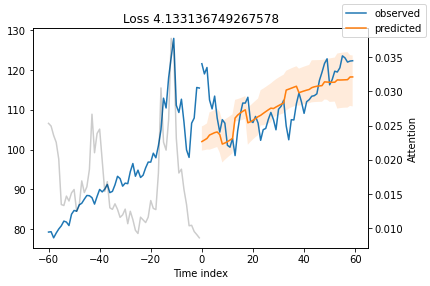

In [88]:
# Loss
#2000 60 -> 60 #24 
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
# plot examples
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

# Interpret model

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x342 with 1 Axes>,
 'encoder_variables': <Figure size 504x648 with 1 Axes>,
 'decoder_variables': <Figure size 504x288 with 1 Axes>}

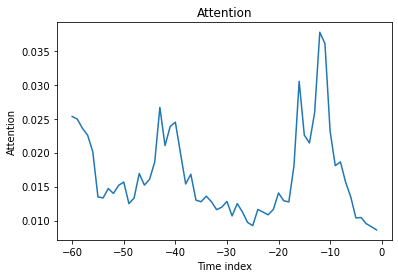

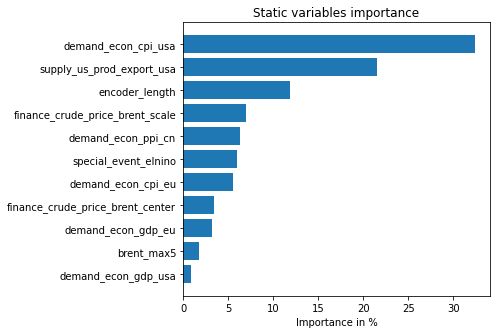

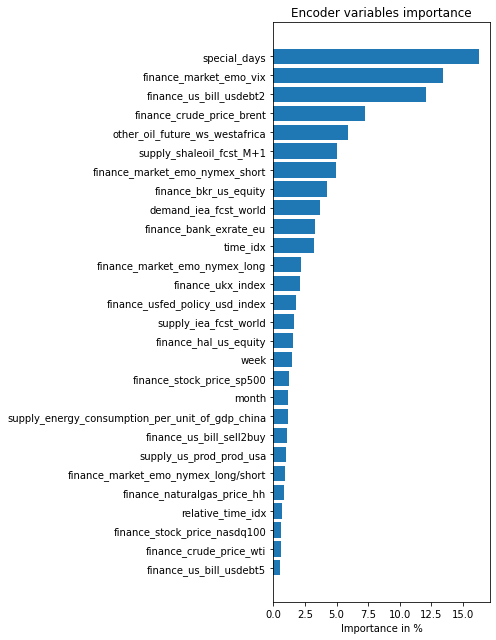

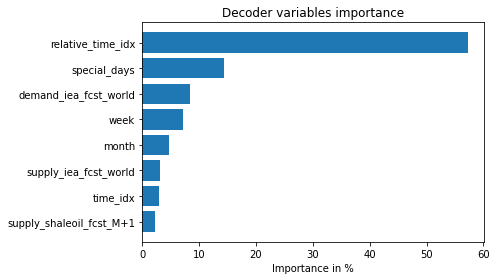

In [89]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
# print(interpretation)
best_tft.plot_interpretation(interpretation)

In [90]:
#daily
data.cal_date = pd.to_datetime(data.cal_date)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]


last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(cal_date=lambda x: x.cal_date + pd.offsets.BusinessDay(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
start = len(data["time_idx"])
end = start + max_prediction_length
step = max_prediction_length
decoder_data["time_idx"] = np.arange(start,end,1)
# adjust additional time feature(s)
decoder_data["week"] = decoder_data.cal_date.dt.week.astype(str).astype("category")  # categories have be strings
decoder_data["month"] = decoder_data.cal_date.dt.month.astype(str).astype("category")  # categories have be strings
encoder_data["cal_date"] = encoder_data["cal_date"].astype(str).astype("category")
decoder_data["cal_date"] = decoder_data["cal_date"].astype(str).astype("category")
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [87]:
#weekly
# data.cal_date = pd.to_datetime(data.cal_date)
# # select last 24 months from data (max_encoder_length is 24)
# encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# # select last known data point and create decoder data from it by repeating it and incrementing the month
# # in a real world dataset, we should not just forward fill the covariates but specify them to account
# # for changes in special days and prices (which you absolutely should do but we are too lazy here)
# last_data = data[lambda x: x.time_idx == x.time_idx.max()]
# decoder_data = pd.concat(
#     [last_data.assign(cal_date=lambda x: x.cal_date + pd.offsets.Week(i)) for i in range(1, max_prediction_length + 1)],
#     ignore_index=True,
# )

# # add time index consistent with "data"
# start = len(data["time_idx"])+1
# end = start + max_prediction_length
# step = max_prediction_length
# decoder_data["time_idx"] = np.arange(start,end,1)
# # adjust additional time feature(s)
# decoder_data["week"] = decoder_data.cal_date.dt.week.astype(str).astype("category")  # categories have be strings
# decoder_data["month"] = decoder_data.cal_date.dt.month.astype(str).astype("category")  # categories have be strings
# encoder_data["cal_date"] = encoder_data["cal_date"].astype(str).astype("category")
# decoder_data["cal_date"] = decoder_data["cal_date"].astype(str).astype("category")
# # combine encoder and decoder data
# new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

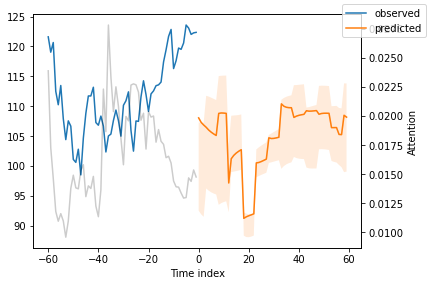

In [91]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False);
# interpretation = best_tft.interpret_output(raw_predictions.iget(slice(0, 0 + 1)))

In [92]:
bullish = []
fair = []
bearish = []

for i in new_raw_predictions[0][0]:
    bearish.append(i[0].numpy().tolist())
    fair.append(i[1].numpy().tolist())
    bullish.append(i[2].numpy().tolist())
hist_price = new_prediction_data['finance_crude_price_brent'].values.tolist()  
date = new_prediction_data['cal_date']  
date = date.to_list()
y = hist_price[0:max_encoder_length]
bearish_price = bearish
fair_price = fair
bullish_price = bullish

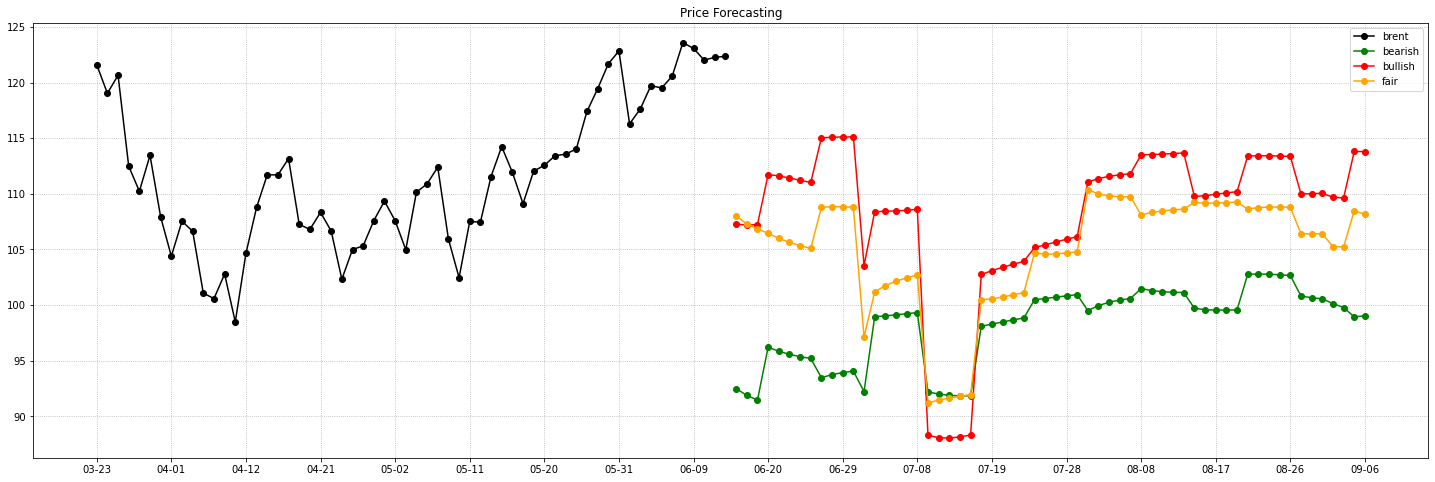

In [99]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
 # pd.to_datetime(data.cal_date)
t =  pd.to_datetime(date)
x1 = pd.DataFrame(bearish_price)
x2 = pd.DataFrame(fair_price)
x3 = pd.DataFrame(bullish_price)
fig, ax = plt.subplots(figsize=(25,8))  # Create a figure and an axes.
plt.grid(linestyle=':')
ax.plot(pd.to_datetime(t[0:max_encoder_length], format='%Y-%m-%d').strftime('%m-%d'),y, label='brent',color = 'black', marker = 'o') 
ax.plot(pd.to_datetime(t[max_encoder_length:],  format='%Y-%m-%d').strftime('%m-%d'),x1, label='bearish',color = 'green' , marker = 'o') 
ax.plot(pd.to_datetime(t[max_encoder_length:],  format='%Y-%m-%d').strftime('%m-%d'),x3, label='bullish',color = 'red', marker = 'o') 
ax.plot(pd.to_datetime(t[max_encoder_length:],  format='%Y-%m-%d').strftime('%m-%d'),x2, label='fair',color = 'orange', marker = 'o') 

ax.title.set_text('Price Forecasting')

ax.xaxis.set_major_locator(mticker.MultipleLocator(7))
ax.legend() 

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x342 with 1 Axes>,
 'encoder_variables': <Figure size 504x648 with 1 Axes>,
 'decoder_variables': <Figure size 504x288 with 1 Axes>}

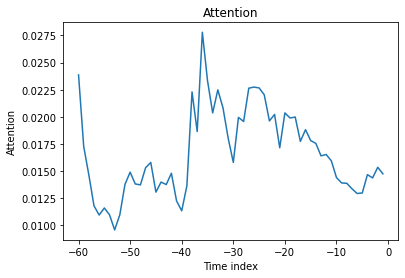

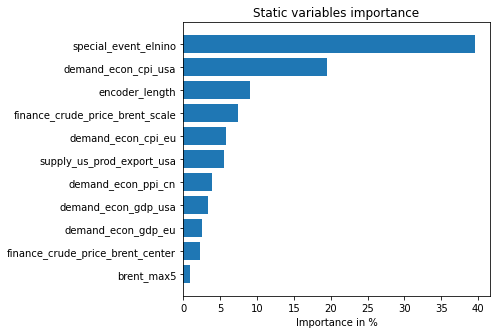

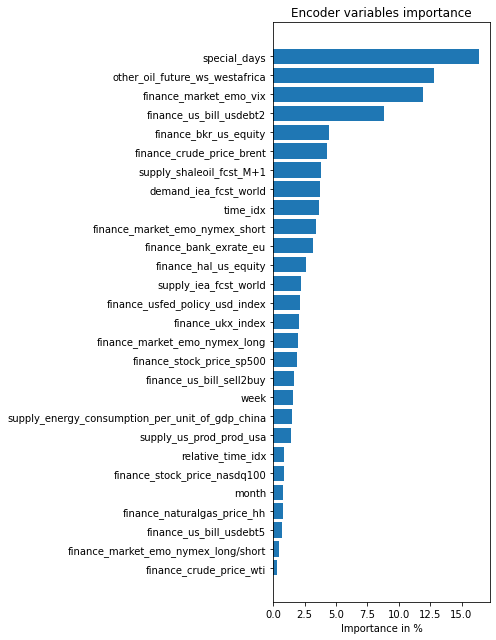

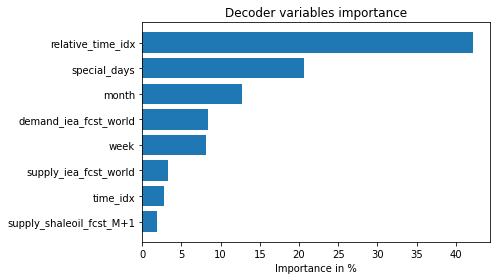

In [94]:
interpretation = best_tft.interpret_output(new_raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)